In [111]:
import pandas as pd
from janitor import clean_names

credit = pd.read_csv('data/german_credit_final.csv')
credit = credit.clean_names()

In [112]:
from sklearn.model_selection import train_test_split

X = credit.drop(columns=['risk'])
y = credit['risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

In [113]:
y.value_counts(normalize=True)

risk
1    0.7
0    0.3
Name: proportion, dtype: float64

In [114]:
y_train.value_counts(normalize=True)

risk
1    0.7
0    0.3
Name: proportion, dtype: float64

In [115]:
y_test.value_counts(normalize=True)

risk
1    0.7
0    0.3
Name: proportion, dtype: float64

# Drzewo decyzyjne

In [116]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

clf_tree = DecisionTreeClassifier(random_state=42, max_depth=4)
clf_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

In [117]:
! pip install matplotlib

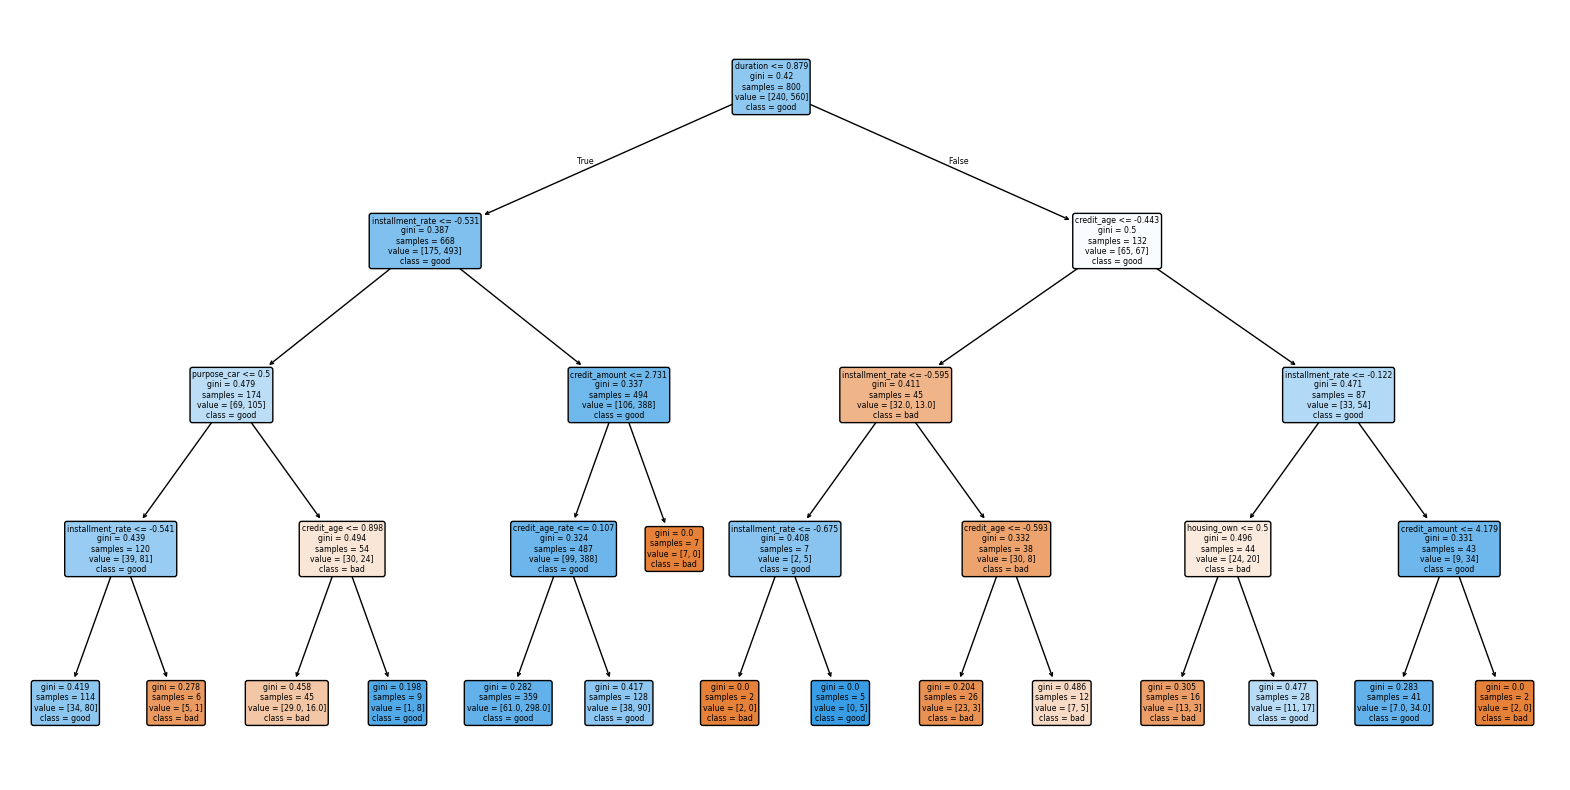

In [118]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(clf_tree, filled=True, feature_names=X.columns, class_names=['bad', 'good'], rounded=True)
plt.show()

## Ocena jakości modelu

In [119]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, balanced_accuracy_score, recall_score, precision_score, f1_score

y_pred_train_tree = clf_tree.predict(X_train)
confusion_matrix(y_train, y_pred_train_tree)

array([[ 88, 152],
       [ 28, 532]])

In [120]:
print(classification_report(y_train, y_pred_train_tree))

              precision    recall  f1-score   support

           0       0.76      0.37      0.49       240
           1       0.78      0.95      0.86       560

    accuracy                           0.78       800
   macro avg       0.77      0.66      0.67       800
weighted avg       0.77      0.78      0.75       800



In [121]:
def evaluate_model(y_true, y_pred):

    print("Confusion Matrix:") 
    print(confusion_matrix(y_true, y_pred))

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    accuracy = accuracy_score(y_true, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    specificity = tn / (tn + fp)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Balanced Accuracy: {balanced_accuracy:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Specificity: {specificity:.4f}')

In [122]:
evaluate_model(y_train, y_pred_train_tree)

Confusion Matrix:
[[ 88 152]
 [ 28 532]]
Accuracy: 0.7750
Balanced Accuracy: 0.6583
Recall: 0.9500
Precision: 0.7778
F1 Score: 0.8553
Specificity: 0.3667


In [123]:
y_pred_test_tree = clf_tree.predict(X_test)
evaluate_model(y_test, y_pred_test_tree)

Confusion Matrix:
[[ 14  46]
 [ 15 125]]
Accuracy: 0.6950
Balanced Accuracy: 0.5631
Recall: 0.8929
Precision: 0.7310
F1 Score: 0.8039
Specificity: 0.2333


Accuracy = 0,695 - 69,5% trafności
Balanced accuracy = 0,56 - trochę powyżej niż dla losowego zgadywania
Recall = 0,89 - udaje się wykryć 89% dobrych klientów, tylko 11% klasyfikuje jako złych
Precision = 0,73 - 73% klientów zaklasyfikowanych jako dobrych to faktycznie Ci co spłacili, model dość pewny dla TP
F1-score = 0,80 - dobra skuteczność dla klasy 'good'
Specificity = 0,23 - tylko 23% złych klientów zostało poprawnie rozpoznanych, 77% złych klientów jest klasyfikowanych jako dobrzy

## Krzywa ROC

In [124]:
from sklearn.metrics import roc_auc_score, roc_curve

y_pred_proba_test_tree = clf_tree.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_test, y_pred_proba_test_tree))

0.604642857142857


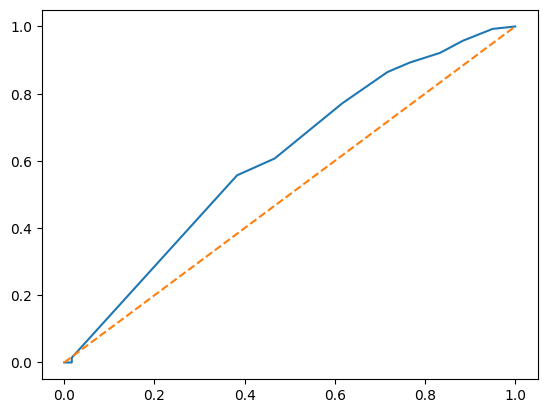

In [125]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test_tree)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')

# SVM

In [126]:
from sklearn.svm import SVC

clf_svm = SVC(random_state=42, probability=True, kernel='rbf')
clf_svm.fit(X_train, y_train)
y_pred_train_svm = clf_svm.predict(X_train)
y_pred_test_svm = clf_svm.predict(X_test)

In [127]:
evaluate_model(y_train, y_pred_train_svm)

Confusion Matrix:
[[ 55 185]
 [  9 551]]
Accuracy: 0.7575
Balanced Accuracy: 0.6065
Recall: 0.9839
Precision: 0.7486
F1 Score: 0.8503
Specificity: 0.2292


In [128]:
evaluate_model(y_test, y_pred_test_svm)

Confusion Matrix:
[[ 10  50]
 [  5 135]]
Accuracy: 0.7250
Balanced Accuracy: 0.5655
Recall: 0.9643
Precision: 0.7297
F1 Score: 0.8308
Specificity: 0.1667


0.6678571428571428


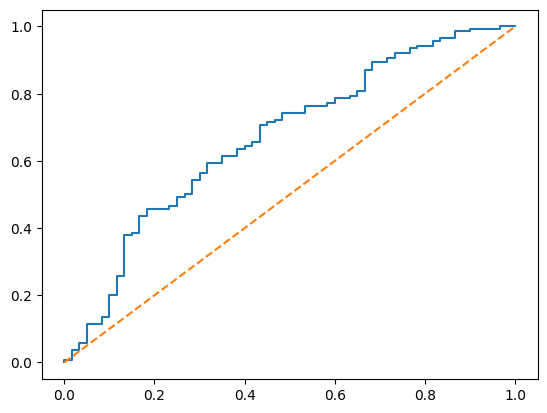

In [129]:
y_pred_proba_test_svm = clf_svm.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_test, y_pred_proba_test_svm))

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test_svm)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')

# Las lasowy

In [130]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(random_state=42, n_estimators=500, max_depth=4)
clf_rf.fit(X_train, y_train)
y_pred_train_rf = clf_rf.predict(X_train)
y_pred_test_rf = clf_rf.predict(X_test)

In [131]:
evaluate_model(y_train, y_pred_train_rf)

Confusion Matrix:
[[ 33 207]
 [  1 559]]
Accuracy: 0.7400
Balanced Accuracy: 0.5679
Recall: 0.9982
Precision: 0.7298
F1 Score: 0.8431
Specificity: 0.1375


In [132]:
evaluate_model(y_test, y_pred_test_rf)

Confusion Matrix:
[[  3  57]
 [  2 138]]
Accuracy: 0.7050
Balanced Accuracy: 0.5179
Recall: 0.9857
Precision: 0.7077
F1 Score: 0.8239
Specificity: 0.0500


0.6564285714285715


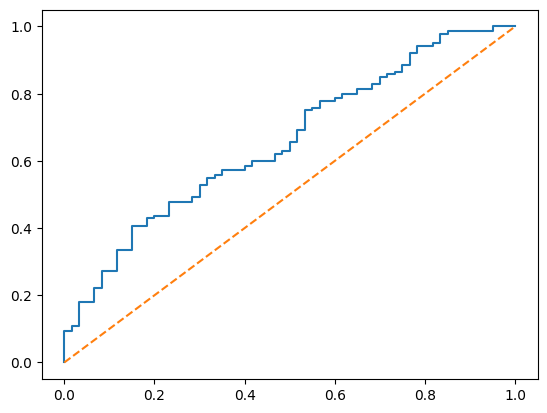

In [133]:
y_pred_proba_test_rf = clf_rf.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_test, y_pred_proba_test_rf))

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test_rf)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')

# Boosting gradientowy

In [134]:
from sklearn.ensemble import GradientBoostingClassifier

clf_gb = GradientBoostingClassifier(random_state=42, n_estimators=100)
clf_gb.fit(X_train, y_train)
y_pred_train_gb = clf_gb.predict(X_train)
y_pred_test_gb = clf_gb.predict(X_test)

In [135]:
evaluate_model(y_train, y_pred_train_gb)

Confusion Matrix:
[[148  92]
 [  6 554]]
Accuracy: 0.8775
Balanced Accuracy: 0.8030
Recall: 0.9893
Precision: 0.8576
F1 Score: 0.9187
Specificity: 0.6167


In [136]:
evaluate_model(y_test, y_pred_test_gb)

Confusion Matrix:
[[ 13  47]
 [ 22 118]]
Accuracy: 0.6550
Balanced Accuracy: 0.5298
Recall: 0.8429
Precision: 0.7152
F1 Score: 0.7738
Specificity: 0.2167


0.6172023809523809


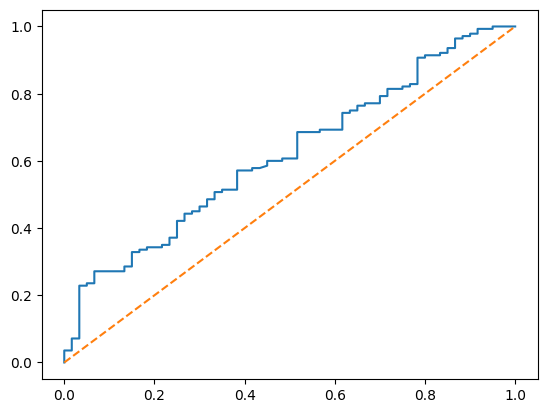

In [137]:
y_pred_proba_test_gb = clf_gb.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_test, y_pred_proba_test_gb))

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test_gb)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')

In [138]:
! pip install xgboost

In [139]:
from xgboost import XGBClassifier

clf_xgb = XGBClassifier(random_state=42, n_estimators=100)
clf_xgb.fit(X_train, y_train)
y_pred_train_xgb = clf_xgb.predict(X_train)
y_pred_test_xgb = clf_xgb.predict(X_test)


In [140]:
evaluate_model(y_train, y_pred_train_xgb)


Confusion Matrix:
[[240   0]
 [  0 560]]
Accuracy: 1.0000
Balanced Accuracy: 1.0000
Recall: 1.0000
Precision: 1.0000
F1 Score: 1.0000
Specificity: 1.0000


In [141]:
evaluate_model(y_test, y_pred_test_xgb)

Confusion Matrix:
[[ 20  40]
 [ 26 114]]
Accuracy: 0.6700
Balanced Accuracy: 0.5738
Recall: 0.8143
Precision: 0.7403
F1 Score: 0.7755
Specificity: 0.3333


0.5939285714285714


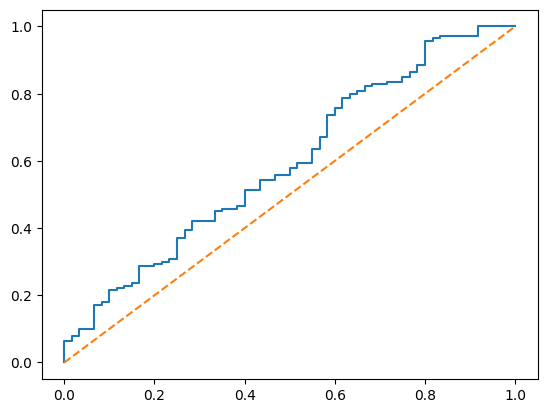

In [142]:
y_pred_proba_test_xgb = clf_xgb.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_test, y_pred_proba_test_xgb))

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test_xgb)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')